# Multilayer thin film optimization

The language of transfer/scatter matrices is commonly used to calculate optical properties of thin-films [1]. Various analytical and numerical techniques have been developed to optimize multilayer thin films as a function of desired performance. Many commercial and even open-source [2] software have been developed to great effect. SAX can also be used to apply automatic differentiation to this problem.

[1] https://www.photonics.intec.ugent.be/download/ocs129.pdf
[2] Larouche, S., & Martinu, L. (2008). OpenFilters: open-source software for the design, optimization, and synthesis of optical filters. Appl. Opt., 47(13), C219–C230. doi: 10.1364/AO.47.00C219

## Imports

In [1]:
import tqdm
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.experimental.optimizers as opt

# sax circuit simulator
import sys
sys.path.append("..")
import sax

## Fabry-Pérot cavity

Consider a stack composed of only two materials, one high index $n_A$ and one low-index $n_B$. Two types of transfer matrices characterize wave propagation in the system : interfaces described by Fresnel's equations, and propagation.

In [2]:
# Reflection at i-->j interface
def r_ij(params):
    """
    Normal incidence amplitude reflection from Fresnel's equations
    ni : refractive index of the initial medium
    nf : refractive index of the final
    """
    return (params["ni"] - params["nj"]) / (params["ni"] + params["nj"])

# Transmission at i-->j interface
def t_ij(params):
    """
    Normal incidence amplitude transmission from Fresnel's equations
    """
    return 2 * params["ni"] / (params["ni"] + params["nj"])

# Propagation through medium A
def prop_i(params):
    """
    Phase shift acquired as a wave propagates through medium A
    wl : wavelength (arb. units)
    ni : refractive index of medium (at wavelength wl)
    di : thickness of layer (same arb. unit as wl)
    """
    return jnp.exp(1j * 2*jnp.pi * params["ni"] / params["wl"] * params["di"])

For the two-material stack, this leads to 4 scatter matrices coefficients. THrough reciprocity they can be constructed out of two independent ones :

In [3]:
# Arbitrary default parameters
interface_ij = {
    ("in", "in"): r_ij,
    ("in", "out"): t_ij,
    ("out", "in"): lambda params: (1 - r_ij(params)**2)/t_ij(params), # t_ji,
    ("out", "out"): lambda params: -1*r_ij(params), # r_ji,
    "default_params": {
        "ni": 1.,
        "nj": 1.,
        "wl": 532.,
    }
}

propagation_i = {
    ("in", "out"): prop_i,
    ("out", "in"): prop_i,
    "default_params": {
        "ni": 1.,
        "di": 1000.,
        "wl": 532.,
    }
}

A resonant cavity can be formed when a high index region is surrounded by low-index region :

In [4]:
fabry_perot = sax.circuit(
    models = {
        "air-B": interface_ij,
        "B": propagation_i,
        "B-air": interface_ij,
    },
    connections={
        "air-B:out": "B:in",
        "B:out": "B-air:in",
    },
    ports={
        "air-B:in": "in",
        "B-air:out": "out",
    },
)

params = fabry_perot["default_params"]
params

{'B-air': {'ni': 1.0, 'nj': 1.0, 'wl': 532.0},
 'air-B': {'ni': 1.0, 'nj': 1.0, 'wl': 532.0},
 'B': {'ni': 1.0, 'di': 1000.0, 'wl': 532.0}}

Let's choose $n_A = 1$, $n_B = 2$, $d_B = 1000$ nm, and compute over the visible spectrum :

In [5]:
params = sax.copy_params(params)
params["air-B"]["nj"] = 2.
params["B"]["ni"] = 2.
params["B-air"]["ni"] = 2.
#print(params)
wls = jnp.linspace(380, 750, 200)
params = sax.set_global_params(params, wl=wls)

Compute transmission and reflection, and compare to another package's results (https://github.com/sbyrnes321/tmm) :

In [6]:
fabry_perot_transmitted = fabry_perot["in","out"]
fabry_perot_transmitted = jax.jit(fabry_perot["in", "out"])
transmitted = fabry_perot_transmitted(params)

fabry_perot_reflected = fabry_perot["in","in"]
fabry_perot_reflected = jax.jit(fabry_perot["in", "in"])
reflected = fabry_perot_reflected(params)

In [7]:
import sys
!$sys.executable -m pip install tmm
from tmm import coh_tmm

# tmm syntax (https://github.com/sbyrnes321/tmm)
d_list = [jnp.inf,1000,jnp.inf]
n_list = [1,2,1]
# initialize lists of y-values to plot
rnorm=[]
tnorm = []
for l in wls:
    rnorm.append(coh_tmm('s',n_list, d_list, 0, l)['r'])
    tnorm.append(coh_tmm('s',n_list, d_list, 0, l)['t'])

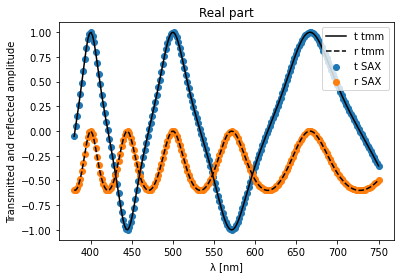

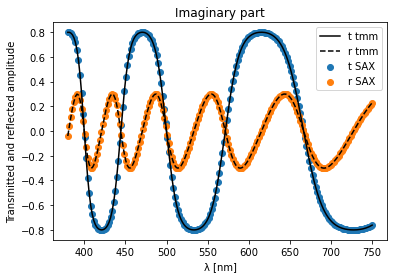

In [8]:
plt.scatter(wls, jnp.real(transmitted), label='t SAX')
plt.plot(wls, jnp.real(jnp.array(tnorm)), 'k', label='t tmm')
plt.scatter(wls, jnp.real(reflected), label='r SAX')
plt.plot(wls, jnp.real(jnp.array(rnorm)), 'k--', label='r tmm')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Real part")
plt.show()

plt.scatter(wls, jnp.imag(transmitted), label='t SAX')
plt.plot(wls, jnp.imag(jnp.array(tnorm)), 'k', label='t tmm')
plt.scatter(wls, jnp.imag(reflected), label='r SAX')
plt.plot(wls, jnp.imag(jnp.array(rnorm)), 'k--', label='r tmm')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Imaginary part")
plt.show()

## Notch filter

Again with only two alternating materials, let's do a notch filter in reflection that reflects for a narrow range of wavelengths around $\lambda_0$, and nowhere else. An intuitive starting point is the stack [1,2]

$$ n_i | \left[ (2-p)ApB\right]^N | n_f $$

with $n_i$ and $n_f$ boundary indices, A and B the respective quarter wave plates at $\lambda_0$

$$ A \rightarrow d=\frac{1}{4}\frac{\lambda_0}{n_A} \text{ of } n_A$$
$$ B \rightarrow d=\frac{1}{4}\frac{\lambda_0}{n_B}  \text{ of } n_B $$

and $p$ is small. From the analytical expressions of [2], we consider materials $n_A = 2.35$, and $n_B = 1.45$, and target $\lambda_0 = 532$ nm. To obtain adequate performance, we use the starting point $p = 0.12$ and $N = 140$. 

[1] https://www.optilayer.com/notch-filters

[2] T.V. Amotchkina, "Analytical estimations for the reference wavelength reflectance and width of high reflection zone of two-material periodic multilayers," Appl. Opt. 52, 4590-4595 (2013).

Let's see how a single such layer surrounded by air performs :

In [9]:
nA = 2.35
nB = 1.45
p = 0.12
wl0 = 532.
ni = 1.
nf = 1.

dA = (2 - p)*wl0/4/nA
dB = p*wl0/4/nB

We will define specific components with default values the (unchanging) indices of refraction

In [10]:
interface_AB = {
    ("in", "in"): r_ij,
    ("in", "out"): t_ij,
    ("out", "in"): lambda params: (1 - r_ij(params)**2)/t_ij(params), # t_ji,
    ("out", "out"): lambda params: -1*r_ij(params), # r_ji,
    "default_params": {
        "ni": nA,
        "nj": nB,
        "wl": 532.,
    }
}

propagation_A = {
    ("in", "out"): prop_i,
    ("out", "in"): prop_i,
    "default_params": {
        "ni": nA,
        "di": dA,
        "wl": 532.,
    }
}

interface_BA = {
    ("in", "in"): r_ij,
    ("in", "out"): t_ij,
    ("out", "in"): lambda params: (1 - r_ij(params)**2)/t_ij(params), # t_ji,
    ("out", "out"): lambda params: -1*r_ij(params), # r_ji,
    "default_params": {
        "ni": nB,
        "nj": nA,
        "wl": 532.,
    }
}

propagation_B = {
    ("in", "out"): prop_i,
    ("out", "in"): prop_i,
    "default_params": {
        "ni": nB,
        "di": dB,
        "wl": 532.,
    }
}

interface_airA = {
    ("in", "in"): r_ij,
    ("in", "out"): t_ij,
    ("out", "in"): lambda params: (1 - r_ij(params)**2)/t_ij(params), # t_ji,
    ("out", "out"): lambda params: -1*r_ij(params), # r_ji,
    "default_params": {
        "ni": 1.,
        "nj": nA,
        "wl": 532.,
    }
}

interface_Bair = {
    ("in", "in"): r_ij,
    ("in", "out"): t_ij,
    ("out", "in"): lambda params: (1 - r_ij(params)**2)/t_ij(params), # t_ji,
    ("out", "out"): lambda params: -1*r_ij(params), # r_ji,
    "default_params": {
        "ni": nB,
        "nj": 1.,
        "wl": 532.,
    }
}

repeated_unit_BCs = sax.circuit(
    models = {
        "air-A": interface_airA,
        "A": propagation_A,
        "AB": interface_AB,
        "B": propagation_B,
        "B-air": interface_Bair,
    },
    connections={
        "air-A:out": "A:in",
        "A:out": "AB:in",
        "AB:out": "B:in",
        "B:out": "B-air:in",
    },
    ports={
        "air-A:in": "in",
        "B-air:out": "out",
    },
)

params = repeated_unit_BCs["default_params"]
params = sax.copy_params(params)

print(params)

{'air-A': {'ni': 1.0, 'nj': 2.35, 'wl': 532.0}, 'A': {'ni': 2.35, 'di': 106.39999999999999, 'wl': 532.0}, 'B-air': {'ni': 1.45, 'nj': 1.0, 'wl': 532.0}, 'AB': {'ni': 2.35, 'nj': 1.45, 'wl': 532.0}, 'B': {'ni': 1.45, 'di': 11.006896551724138, 'wl': 532.0}}


In [11]:
params = sax.set_global_params(params, wl=wls)

repeated_unit_BCs_transmitted = repeated_unit_BCs["in","out"]
transmitted = repeated_unit_BCs_transmitted(params)

repeated_unit_BCs_reflected = repeated_unit_BCs["in","in"]
reflected = repeated_unit_BCs_reflected(params)

In [12]:
# tmm syntax (https://github.com/sbyrnes321/tmm)
d_list = [jnp.inf,dA,dB,jnp.inf]
n_list = [1.,nA,nB,1.]
# initialize lists of y-values to plot
rnorm=[]
tnorm = []
for l in wls:
    rnorm.append(coh_tmm('s',n_list, d_list, 0, l)['r'])
    tnorm.append(coh_tmm('s',n_list, d_list, 0, l)['t'])

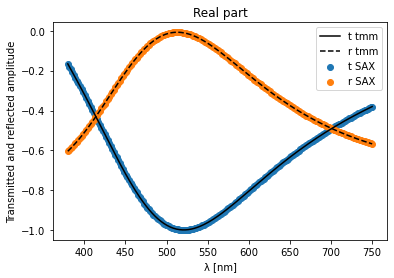

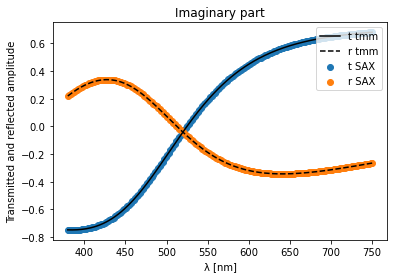

In [13]:
plt.scatter(wls, jnp.real(transmitted), label='t SAX')
plt.plot(wls, jnp.real(jnp.array(tnorm)), 'k', label='t tmm')
plt.scatter(wls, jnp.real(reflected), label='r SAX')
plt.plot(wls, jnp.real(jnp.array(rnorm)), 'k--', label='r tmm')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Real part")
plt.show()

plt.scatter(wls, jnp.imag(transmitted), label='t SAX')
plt.plot(wls, jnp.imag(jnp.array(tnorm)), 'k', label='t tmm')
plt.scatter(wls, jnp.imag(reflected), label='r SAX')
plt.plot(wls, jnp.imag(jnp.array(rnorm)), 'k--', label='r tmm')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Imaginary part")
plt.show()

A single layer does not look notch-like, but the SAX approach does replicate the calculation from the other solver. Repeating the middle part $N$ times to define the full notch filter :

In [14]:
def notch_filter(N=1):
    
    models_dict = {}
    connections_dict = {}
    
    models_dict["air-0_A"] = interface_airA
    connections_dict["air-0_A:out"] = "0_A:in"
    
    # First N-1 layers
    for i in range(N):
        models_dict[f"{i}_A"] = propagation_A
        models_dict[f"{i}_A-B"] = interface_AB
        models_dict[f"{i}_B"] = propagation_B
        models_dict[f"{i}_B-A"] = interface_BA
        
        connections_dict[f"{i}_A:out"] = f"{i}_A-B:in"
        connections_dict[f"{i}_A-B:out"] = f"{i}_B:in"
        connections_dict[f"{i}_B:out"] = f"{i}_B-A:in"
        connections_dict[f"{i}_B-A:out"] = f"{i+1}_A:in"

    # Last layer (no BA interface)
    models_dict[f"{N}_A"] = propagation_A
    models_dict[f"{N}_A-B"] = interface_AB
    models_dict[f"{N}_B"] = propagation_B
    models_dict[f"{N}_B-air"] = interface_Bair
    
    connections_dict[f"{N}_A:out"] = f"{N}_A-B:in"
    connections_dict[f"{N}_A-B:out"] = f"{N}_B:in"
    connections_dict[f"{N}_B:out"] = f"{N}_B-air:in"

    stack = sax.circuit(
        models = models_dict,
        connections = connections_dict,
        ports = {
            "air-0_A:in": "in",
            f"{N}_B-air:out": "out",
        },
    )
    
    return stack

In [15]:
N = 1

stack = notch_filter(N)
print(stack)
params = sax.copy_params(stack["default_params"])

{'default_params': {'1_B-air': {'ni': 1.45, 'nj': 1.0, 'wl': 532.0}, '1_A-B': {'ni': 2.35, 'nj': 1.45, 'wl': 532.0}, '1_B': {'ni': 1.45, 'di': 11.006896551724138, 'wl': 532.0}, 'air-0_A': {'ni': 1.0, 'nj': 2.35, 'wl': 532.0}, '0_A': {'ni': 2.35, 'di': 106.39999999999999, 'wl': 532.0}, '0_B-A': {'ni': 1.45, 'nj': 2.35, 'wl': 532.0}, '1_A': {'ni': 2.35, 'di': 106.39999999999999, 'wl': 532.0}, '0_A-B': {'ni': 2.35, 'nj': 1.45, 'wl': 532.0}, '0_B': {'ni': 1.45, 'di': 11.006896551724138, 'wl': 532.0}}, ('out', 'out'): <function _model_ijkl at 0x7fdacbee9950>, ('out', 'in'): <function _model_ijkl at 0x7fdacbee9950>, ('in', 'out'): <function _model_ijkl at 0x7fdacbee9950>, ('in', 'in'): <function _model_ijkl at 0x7fdacbee9950>}


We can now proceed to simulation :

In [16]:
params = sax.set_global_params(params, wl=wls)

stack_transmitted = stack["in","out"]
%time transmitted = stack_transmitted(params)

stack_reflected = stack["in","in"]
%time reflected = stack_reflected(params)

CPU times: user 83.6 ms, sys: 9.58 ms, total: 93.2 ms
Wall time: 68.7 ms
CPU times: user 114 ms, sys: 11.6 ms, total: 125 ms
Wall time: 95.4 ms


Again compare :

In [17]:
d_list = []
n_list = []

d_list.append(jnp.inf)
n_list.append(1.)

for i in range(N+1): # From way N defined in stack circuit
    d_list.append(dA)
    n_list.append(nA)
    d_list.append(dB)
    n_list.append(nB)

d_list.append(jnp.inf)
n_list.append(1.)

print(d_list)
print(n_list)

rnorm=[]
tnorm = []
for l in wls:
    rnorm.append(coh_tmm('s',n_list, d_list, 0, l)['r'])
    tnorm.append(coh_tmm('s',n_list, d_list, 0, l)['t'])

[inf, 106.39999999999999, 11.006896551724138, 106.39999999999999, 11.006896551724138, inf]
[1.0, 2.35, 1.45, 2.35, 1.45, 1.0]


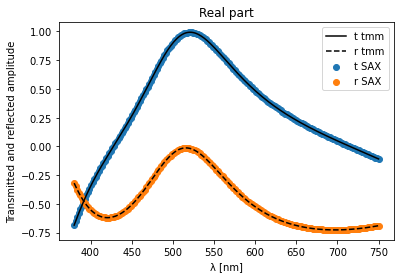

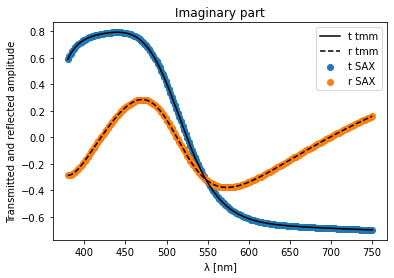

In [18]:
plt.scatter(wls, jnp.real(transmitted), label='t SAX')
plt.plot(wls, jnp.real(jnp.array(tnorm)), 'k', label='t tmm')
plt.scatter(wls, jnp.real(reflected), label='r SAX')
plt.plot(wls, jnp.real(jnp.array(rnorm)), 'k--', label='r tmm')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Real part")
plt.show()

plt.scatter(wls, jnp.imag(transmitted), label='t SAX')
plt.plot(wls, jnp.imag(jnp.array(tnorm)), 'k', label='t tmm')
plt.scatter(wls, jnp.imag(reflected), label='r SAX')
plt.plot(wls, jnp.imag(jnp.array(rnorm)), 'k--', label='r tmm')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Imaginary part")
plt.show()

It is consistent for $N=1$. Adding more layers :

In [19]:
N = 10

stack = notch_filter(N)
params = sax.copy_params(stack["default_params"])

In [20]:
params = sax.set_global_params(params, wl=wls)

stack_reflected = stack["in","in"]
%time reflected = stack_reflected(params)

CPU times: user 3.59 s, sys: 446 ms, total: 4.03 s
Wall time: 3.12 s


Again compare :

In [21]:
d_list = []
n_list = []

d_list.append(jnp.inf)
n_list.append(1.)

for i in range(N+1): # From way N defined in stack circuit
    d_list.append(dA)
    n_list.append(nA)
    d_list.append(dB)
    n_list.append(nB)

d_list.append(jnp.inf)
n_list.append(1.)

Rnorm=[]
for l in wls:
    Rnorm.append(coh_tmm('s',n_list, d_list, 0, l)['R'])

Looking at reflected intensity this time :

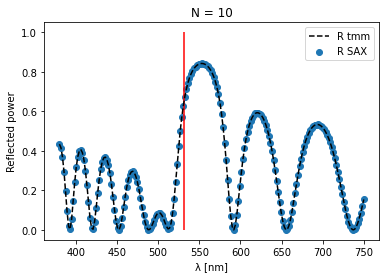

In [22]:
plt.scatter(wls, jnp.abs(reflected)**2, label='R SAX')
plt.plot(wls, Rnorm, 'k--', label='R tmm')
plt.vlines(wl0, ymin=0, ymax=1, color='r')
plt.xlabel("λ [nm]")
plt.ylabel("Reflected power")
plt.legend(loc="upper right")
plt.title("N = {}".format(N))
plt.show()

Now we start to see notch behaviour. The reflection can be brought closer vertically to $1$ by increasing the number of layers even more. The ripples, however, must be optimized away by tuning the widths of the layers from this starting point. We can use the SAX autograd to do this, and speed up the optimization by JIT-ing the function.

We will see if our model compiles properly :

In [23]:
stack_r_jit = jax.jit(stack["in", "in"])

In [24]:
%time reflected = stack_r_jit(params)

CPU times: user 27.1 s, sys: 281 ms, total: 27.4 s
Wall time: 27.4 s


In [25]:
%time reflected = stack_r_jit(params)

CPU times: user 4.15 ms, sys: 1.94 ms, total: 6.09 ms
Wall time: 2.91 ms


Define a target spectrum, and initial vector :

In [26]:
jnp.where(wls < 510)[0][-1]

DeviceArray(69, dtype=int32)

In [27]:
target = jnp.zeros(len(wls))
target = jax.ops.index_update(target, jax.ops.index[jnp.where(wls < 530)[0][-1]:jnp.where(wls > 570)[0][0]], 1.)

initial_vector = dA*jnp.ones(2*N+2)
initial_vector = jax.ops.index_update(initial_vector, jax.ops.index[1::2], dB)

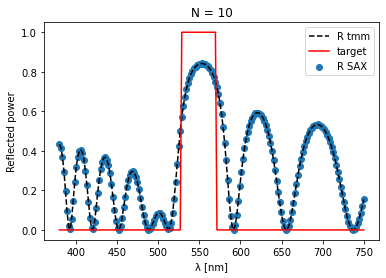

In [28]:
plt.scatter(wls, jnp.abs(reflected)**2, label='R SAX')
plt.plot(wls, Rnorm, 'k--', label='R tmm')
plt.plot(wls, target,'r',label='target')
plt.xlabel("λ [nm]")
plt.ylabel("Reflected power")
plt.legend(loc="upper right")
plt.title("N = {}".format(N))
plt.show()

Optimizing in terms of all the layer thicknesses :

In [29]:
@jax.jit
def loss(dds):
    params = sax.copy_params(stack["default_params"])
    # Update parameters
    for i in range(N):
        params[f"{i}_A"]['di'] = dds[2*i]
        params[f"{i}_B"]['di'] = dds[2*i+1]
        
    params[f"{N}_A"]['di'] = dds[2*N]
    params[f"{N}_B"]['di'] = dds[2*N+1]

    params = sax.set_global_params(params, wl=wls)
        
    reflected = stack["in","in"](params)

    return (abs(reflected)**2 - target).mean()

In [30]:
# JIT the loss function (including computation)
# Evaluate at initial values
%time loss(initial_vector)

CPU times: user 12.7 s, sys: 36.3 ms, total: 12.7 s
Wall time: 12.7 s


DeviceArray(0.20269333, dtype=float32)

In [31]:
%time loss(initial_vector)

CPU times: user 515 µs, sys: 8 µs, total: 523 µs
Wall time: 278 µs


DeviceArray(0.20269333, dtype=float32)

In [ ]:
%time grad_test = jax.grad(loss)(initial_vector)